In [12]:
import pandas as pd
import pymysql
from matplotlib import pyplot as plt
import numpy as np
import yaml
with open('../config.yml') as f:
    config = yaml.load(f)

project_dir = config['PROJECT']
project_db_dir = config['DATABASE']


In [20]:

con = pymysql.connect(host=config['MYSQL_HOST'], user=config['MYSQL_USER'], passwd=config['MYSQL_PASSWD'], 
                      db=config['MYSQL_DB'])

cur = con.cursor()

conservation_scores = {}

for score_type in ['ptm_exact_match_score', 'benign_exact_match_score', 'vus_exact_match_score', 'pathogenic_exact_match_score', 
                          'exact_match_score']:
    if score_type != 'exact_match_score':
        and_where = " AND aminoacid_number >= 10 "
    conservation_scores[score_type] = pd.read_sql("""
        SELECT 
                   min(transcript_id) AS transcript_id,
                   gene_symbol,
                   specie as species,
                   score_type,
                   ( cs.score / cs.aminoacid_number ) AS conservation
            FROM   conservation_scores AS cs
            WHERE  score_type = '""" + score_type + """'
                   """ + and_where + """
            GROUP  BY specie,
                      transcript_id
            """, con)



        SELECT 
                   min(cs_id) AS transcript_id,
                   gene_symbol,
                   specie as species,
                   score_type,
                   ( cs.score / cs.aminoacid_number ) AS conservation
            FROM   conservation_scores AS cs
            WHERE  score_type = 'ptm_exact_match_score'
                   AND Length(gene_symbol) > 0  AND aminoacid_number >= 10 
            GROUP  BY specie,
                      transcript_id
            

        SELECT 
                   min(cs_id) AS transcript_id,
                   gene_symbol,
                   specie as species,
                   score_type,
                   ( cs.score / cs.aminoacid_number ) AS conservation
            FROM   conservation_scores AS cs
            WHERE  score_type = 'benign_exact_match_score'
                   AND Length(gene_symbol) > 0  AND aminoacid_number >= 10 
            GROUP  BY specie,
                      transcript_id
            

        SELE

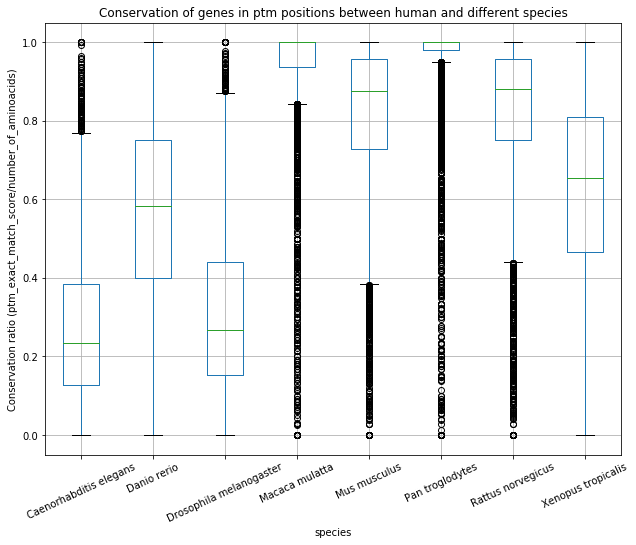

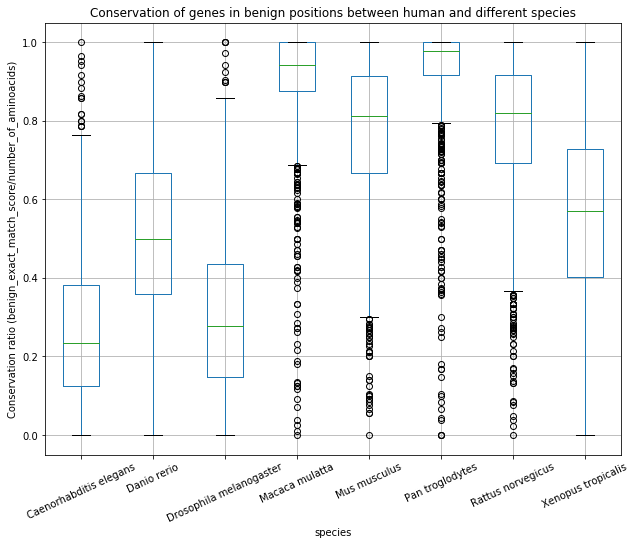

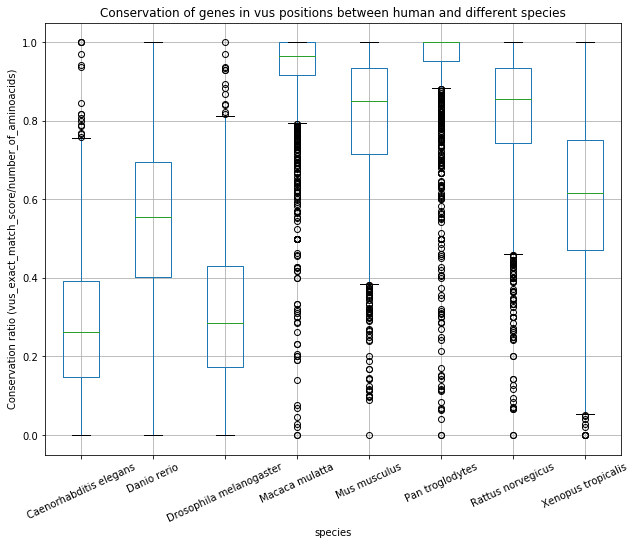

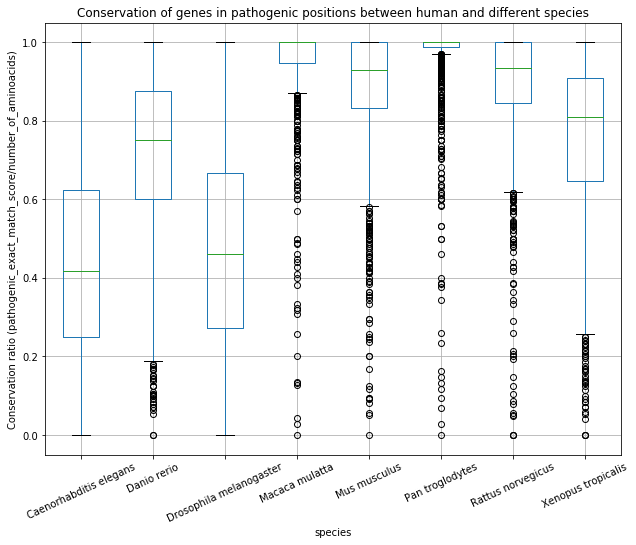

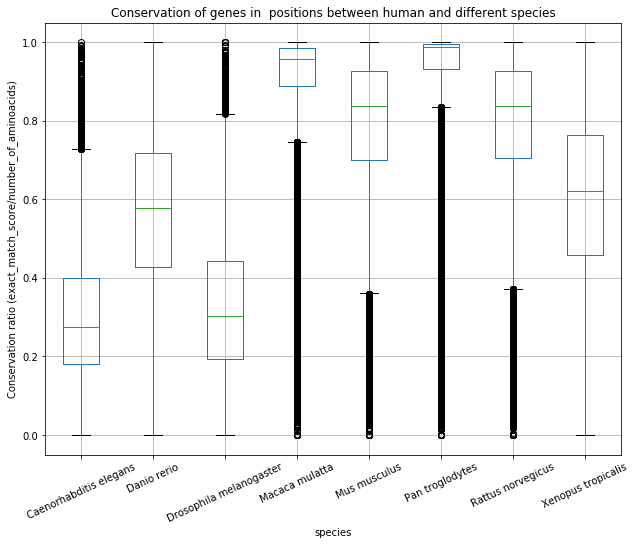

In [22]:
for score_type, scores in conservation_scores.items():
    
    plt.rcParams['figure.figsize'] = [10, 8]

    scores.boxplot('conservation', by='species')
    plt.xticks(rotation=25)
    plt.ylabel('Conservation ratio ('+score_type+'/number_of_aminoacids)')
    significance = score_type.split('_exact_match_score')[0] if '_exact' in score_type else ''
    
    plt.title('Conservation of genes in ' +significance+ ' positions between human and different species')
    plt.suptitle('')
    plt.show()


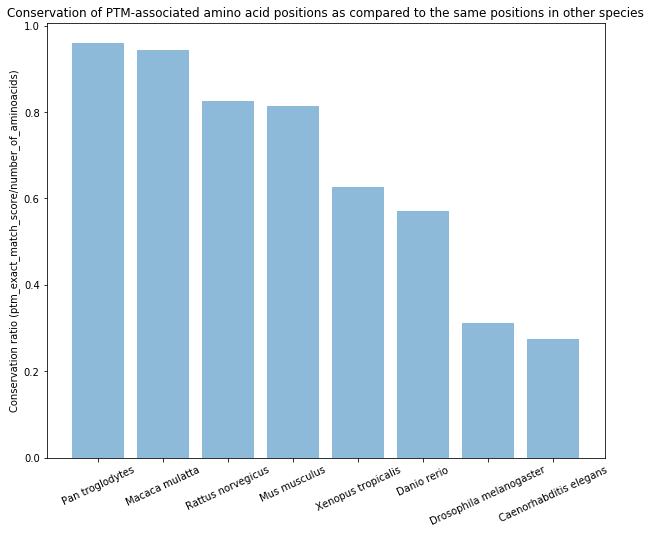

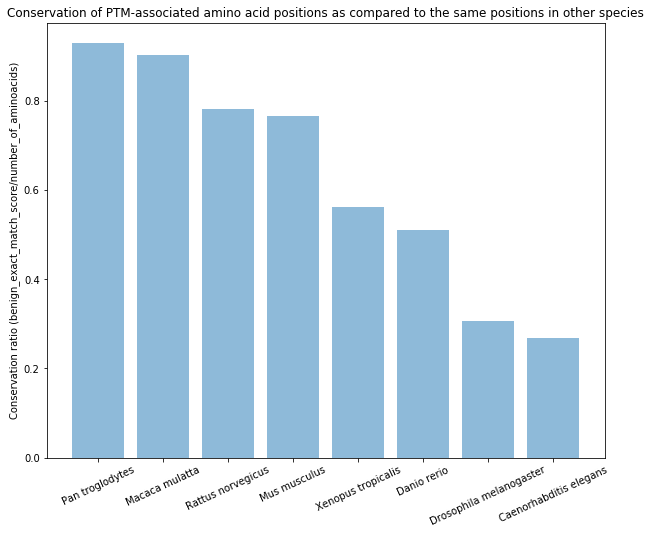

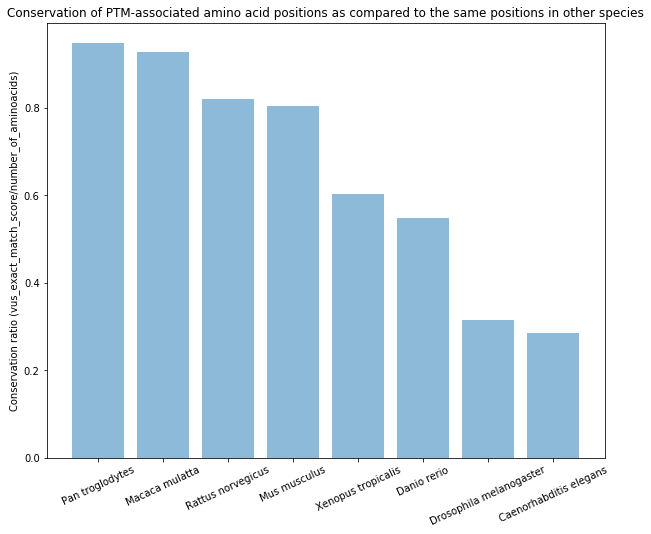

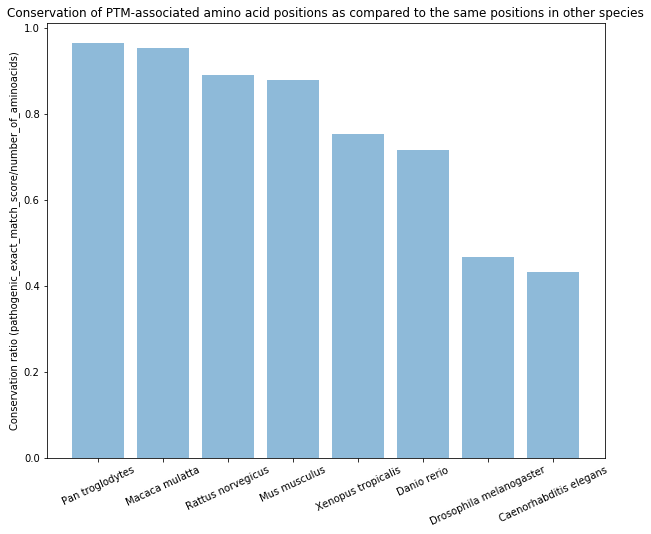

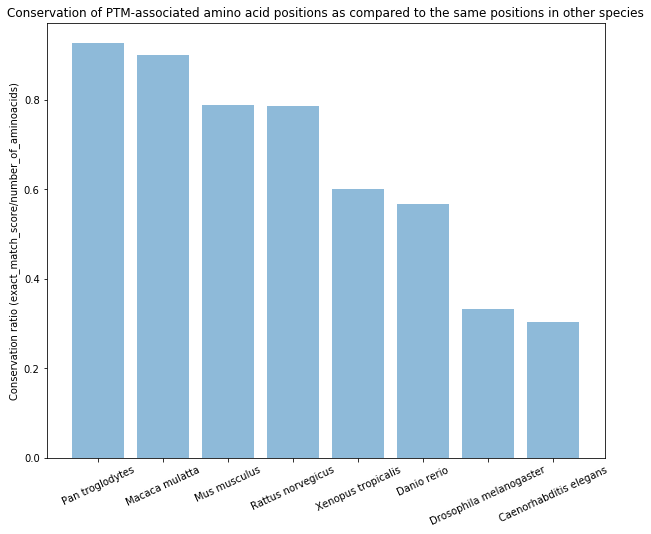

In [23]:
for score_type, scores in conservation_scores.items():
    
    plt.rcParams['figure.figsize'] = [10, 8]
    conservation = scores.groupby('species')['conservation'].agg('mean').sort_values(ascending=False)
    y_pos = np.arange(conservation.shape[0])

    plt.bar(y_pos, conservation.values, align='center', alpha=0.5)
    plt.xticks(y_pos, conservation.index)


    plt.xticks(rotation=25)
    plt.ylabel('Conservation ratio ('+score_type+'/number_of_aminoacids)')
    significance = 'in ' + score_type.split('_exact_match_score')[0] + ' variation positions' if '_exact' in score_type else ''
    
    plt.title('Conservation of PTM-associated amino acid positions as compared to the same positions in other species')
    plt.suptitle('')
    plt.show()
    

/home/kaplanlab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


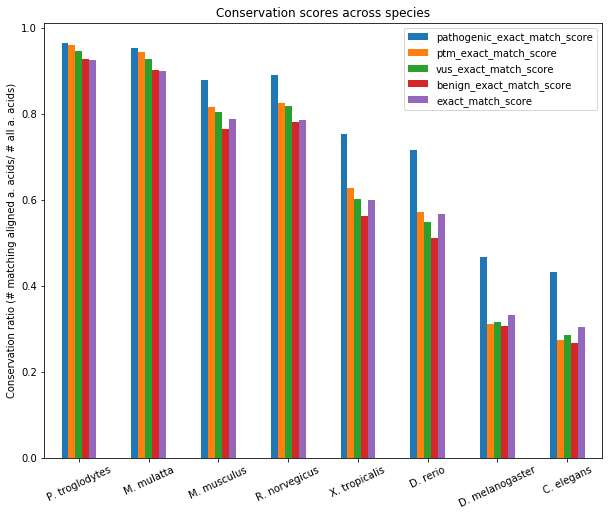

In [24]:
conservations_by_species = pd.DataFrame()

for score_type, scores in conservation_scores.items():
    
    conservation = scores.groupby('species')['conservation'].agg('mean').sort_values(ascending=False)
    
    conservations_by_species = pd.concat([conservations_by_species, conservation], axis=1)
    n_cols = len(conservations_by_species.columns)-1
    conservations_by_species.columns = [score_type if i ==n_cols else col for i,col in enumerate(conservations_by_species.columns) ]

plt.rcParams['figure.figsize'] = [10, 8]    
conservations_by_species = conservations_by_species.sort_values(by='exact_match_score', ascending=False)
conservations_by_species = conservations_by_species.sort_values('Macaca mulatta', axis=1, ascending=False)
conservations_by_species.plot(kind='bar')
plt.title('Conservation scores across species')
plt.ylabel('Conservation ratio (# matching aligned a. acids/ # all a. acids)')

locs, labels = plt.xticks()
plt.xticks(np.arange(8), ('P. troglodytes','M. mulatta','M. musculus','R. norvegicus','X. tropicalis','D. rerio','D. melanogaster','C. elegans'), rotation=25)
#plt.xticks(rotation=90)
plt.show()

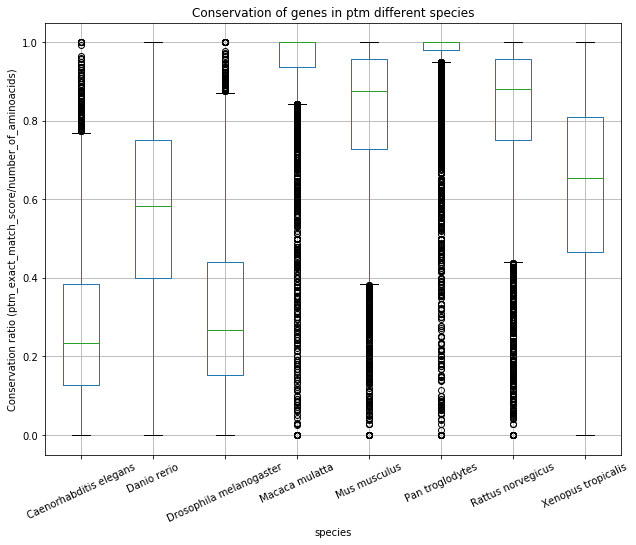

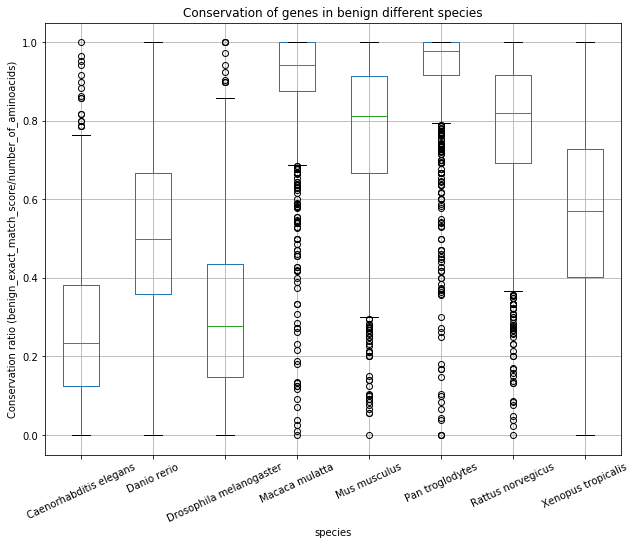

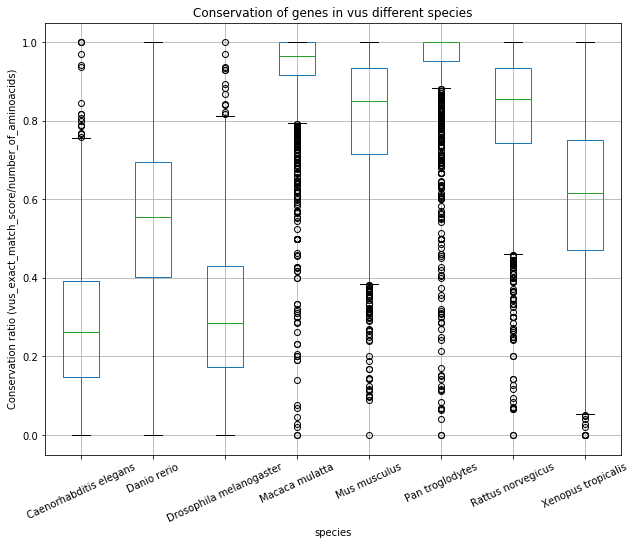

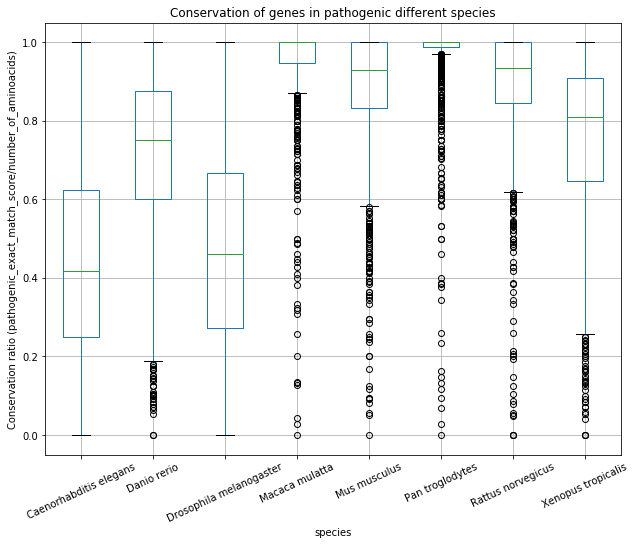

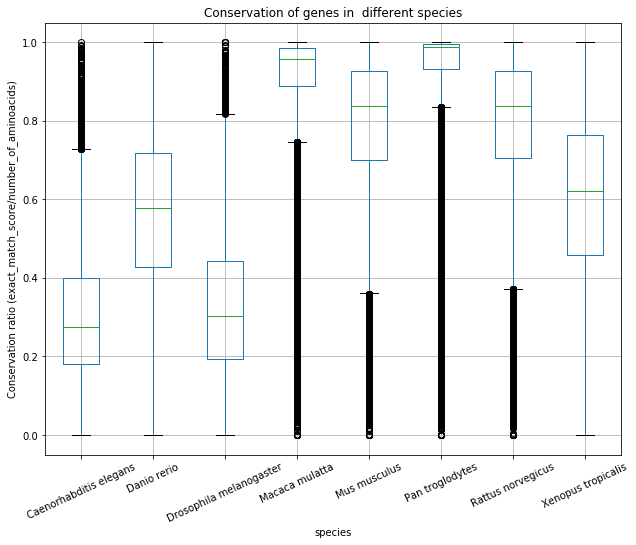

In [25]:
for score_type, scores in conservation_scores.items():
    
    plt.rcParams['figure.figsize'] = [10, 8]

    scores.boxplot('conservation', by='species')
    plt.xticks(rotation=25)
    plt.ylabel('Conservation ratio ('+score_type+'/number_of_aminoacids)')
    significance = score_type.split('_exact_match_score')[0] if '_exact' in score_type else ''
    
    plt.title('Conservation of genes in ' +significance+ ' different species')
    plt.suptitle('')
    plt.show()


In [26]:
def sqlize(significance_list):
	return "'"+ "', '".join(significance_list) + "'"

benign_list = sqlize(["Benign","Benign, association","Benign/Likely benign","Benign/Likely benign, Affects","Benign/Likely benign, association",
			"Benign/Likely benign, drug response","Benign/Likely benign, drug response, risk factor","Benign/Likely benign, other","Benign/Likely benign, protective",
			"Benign/Likely benign, protective, risk factor","Benign/Likely benign, risk factor","Benign, other","Benign, risk factor","Likely benign",
			"Likely benign, drug response, other","Likely benign, other","Likely benign, risk factor"])
vus_list = sqlize(["Uncertain significance","Uncertain significance, drug response","Uncertain significance, other","Uncertain significance, risk factor"])
pathogenic_list = sqlize(["Pathogenic","Pathogenic, Affects","Pathogenic, association, protective","Pathogenic, drug response","Pathogenic/Likely pathogenic",
"Pathogenic/Likely pathogenic, drug response","Pathogenic/Likely pathogenic, other","Pathogenic/Likely pathogenic, risk factor","Pathogenic, other",
"Pathogenic, other, risk factor","Pathogenic, protective","Pathogenic, risk factor","Likely pathogenic","Likely pathogenic, association",
"Likely pathogenic, drug response","Likely pathogenic, other","Likely pathogenic, risk factor"])

significance_lists = {
    'benign': benign_list,
    'vus': vus_list,
    'pathogenic': pathogenic_list
}
aminoacid_to_single_letter = {
    'Ala': 'A','Arg': 'R','Asn': 'N','Asp': 'D','Asx': 'B',
    'Cys': 'C','Glu': 'E','Gln': 'Q','Glx': 'Z','Gly': 'G','His': 'H',
    'Ile': 'I','Leu': 'L','Lys': 'K','Met': 'M','Phe': 'F','Pro': 'P',
    'Ser': 'S','Thr': 'T','Trp': 'W','Tyr': 'Y','Val': 'V',
}

In [27]:
genes = pd.read_sql("SELECT sequence FROM convart_gene WHERE species_id='Homo sapiens'", con)
combined_genes = ''.join(genes['sequence'])

aminoacid_count = {}

for aminoacid in combined_genes:
    if aminoacid not in aminoacid_count:
        aminoacid_count[aminoacid] = 0
    aminoacid_count[aminoacid] += 1
aminoacid_count = pd.DataFrame.from_dict(aminoacid_count, orient='index')

In [28]:
import re
def get_original_aminoacid(variation):
    try:
        aminoacid_search =  re.search(r'^(\(|)p\.([a-zA-Z][a-zA-Z][a-zA-Z]|[a-zA-Z])', variation)
        if len(aminoacid_search.group(2))==1:
            return aminoacid_search.group(2)
        else:
            return aminoacid_to_single_letter[aminoacid_search.group(2)]
    except:
        return None

variant_aminoacid_count_by_significance = pd.DataFrame()
for significance, significance_list in significance_lists.items():
    variations = pd.read_sql("SELECT variation FROM `clinvar` WHERE clinical_significance IN ("+significance_list+")"+
                             " AND variation != ''", con)
    variations.loc[:, 'original_aminoacid'] = variations['variation'].apply(get_original_aminoacid)
    positions = variations.groupby('original_aminoacid').size()
    variant_aminoacid_count_by_significance = pd.concat([variant_aminoacid_count_by_significance, positions], axis=1)
    n_cols = variant_aminoacid_count_by_significance.shape[1] -1
    variant_aminoacid_count_by_significance.columns = [significance if i ==n_cols else col for i,col in 
                                                       enumerate(variant_aminoacid_count_by_significance.columns) ]
variant_aminoacid_count_by_significance['all_genes'] = aminoacid_count

variant_aminoacid_count_by_significance = variant_aminoacid_count_by_significance / variant_aminoacid_count_by_significance.sum(axis=0)

/home/kaplanlab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

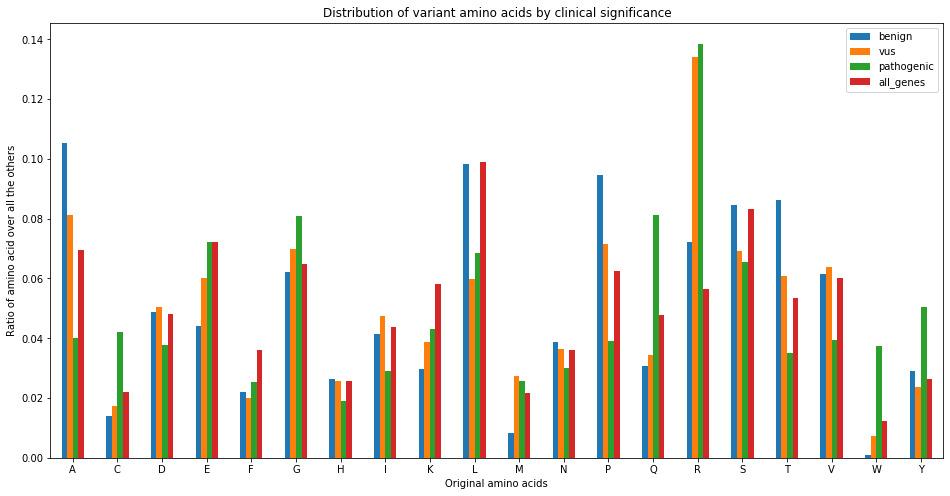

In [29]:
plt.rcParams['figure.figsize'] = [16, 8]
variant_aminoacid_count_by_significance.plot(kind='bar')
plt.ylabel('Ratio of amino acid over all the others')
plt.xlabel('Original amino acids')
plt.title('Distribution of variant amino acids by clinical significance')
plt.xticks(rotation=0)